# Simulating ion current models

In this example, we simulate some ion currents, in response to voltage-step protocols.

We start simple, by loading a model and protocol from disk, creating a standard Simulation engine, running a simulation and plotting the results.

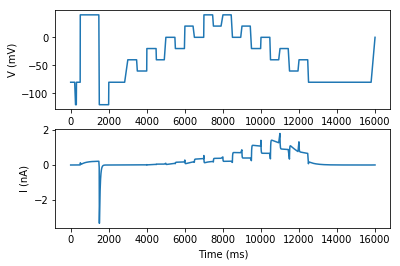

In [3]:
import myokit

m = myokit.load_model('beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('staircase-protocol.mmt')
s = myokit.Simulation(m, p)

d = s.run(p.characteristic_time())

import matplotlib.pyplot as plt
plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.plot(d.time(), d['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d.time(), d['ikr.IKr'])

plt.show()

That seems to have worked, so lets have a look at some of the details we've glossed over:

1. The model and protocol files we loaded can be found in the same directory as this notebook.

2. When we ran `d = s.run(p.characteristic_time())`, we used the `characteristic_time()` method of Myokit's `Protocol` class to get the protocol duration. Instead, we could have simply written `d = s.run(16000)`

3. When plotting, we used `d['ikr.IKr']` to select the data logged for variable `IKr` from the component `ikr`. We can see what other variables are available by inspecting the model code:

In [4]:
print(m.code())

[[model]]
author: Michael Clerx
name: Beattie-2017-IKr
# Initial values
ikr.act = 0
ikr.rec = 1

[engine]
time = 0 [ms] bind time

[ikr]
use membrane.V as V
IKr = g * act * rec * (V - nernst.EK)
    in [nA]
dot(act) = (inf - act) / tau
    inf = k1 * tau
    k1 = p1 * exp(p2 * V)
    k2 = p3 * exp(-p4 * V)
    tau = 1 / (k1 + k2)
g = p9
p1 = 0.000226 [mS/uF]
p2 = 0.0699 [1/mV]
p3 = 3.45e-5 [mS/uF]
p4 = 0.05462 [1/mV]
p5 = 0.0873 [mS/uF]
p6 = 0.00891 [1/mV]
p7 = 0.00515 [mS/uF]
p8 = 0.03158 [1/mV]
p9 = 0.1524 [uS]
dot(rec) = (inf - rec) / tau
    inf = k4 * tau
    k3 = p5 * exp(p6 * V)
    k4 = p7 * exp(-p8 * V)
    tau = 1 / (k3 + k4)

[membrane]
V = -80 [mV] bind pace

[nernst]
EK = -85 [mV]




4. The method `d.time()` uses meta-information stored in the log to return the data for the variable labelled as time. Instead of this, we could have looked at the model code and written `d['engine.time']`.

5. How do the protocol and the model interact? The protocol defines a series of steps, which make up a dimensionless (and typically discontinuous) variable called the "pacing variable" in the Myokit docs. The model designates the variable `membrane.V` as an entry point for the pacing variable, by _binding_ it to the keyword "pace".

In [5]:
# We can see this by inspecting the code for `membrane.V`
print(m.get('membrane.V').code())

V = -80 [mV] bind pace



In [6]:
# Or using the model API
print(m.get('membrane.V').binding())

pace


6. The membrane potential looks a bit dodgy. In particular, there appear to be ramp-like bits, and there's a jump to 0mV right at the very end of the simulation. What's going on there?

First, the ramp-like bits: These are plotting artefacts, that arise because the `Simulation` class uses an adaptive step-size solver. As a result, if the step just before a voltage-transition is a large one, the resulting plot looks like it has a ramp in it.

We can see this effect more clearly by using a different plotting method:

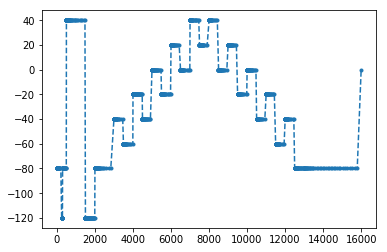

In [7]:
plt.figure()
plt.plot(d.time(), d['membrane.V'], '.--')
plt.show()

This clearly shows that all the actual data points are at the levels specified in the protocol, while the bits that appear to be ramps are plotting artefacts.

Knowing this, we might choose to use a different plotting method (i.e. that doesn't interpolate) for the membrane potential:

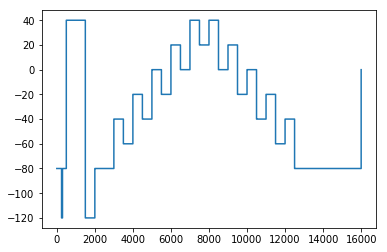

In [8]:
plt.figure()
plt.plot(d.time(), d['membrane.V'], drawstyle='steps-post')
plt.show()

Finally, at t=16000ms we see a jump to 0mV. This doesn't appear to be defined in the protocol:

In [9]:
print(p.code())

[[protocol]]
# Level  Start    Length   Period   Multiplier
-80.0    0.0      250.0    0.0      0
-120.0   250.0    50.0     0.0      0
-80.0    300.0    200.0    0.0      0
40.0     500.0    1000.0   0.0      0
-120.0   1500.0   500.0    0.0      0
-80.0    2000.0   1000.0   0.0      0
-40.0    3000.0   500.0    0.0      0
-60.0    3500.0   500.0    0.0      0
-20.0    4000.0   500.0    0.0      0
-40.0    4500.0   500.0    0.0      0
0.0      5000.0   500.0    0.0      0
-20.0    5500.0   500.0    0.0      0
20.0     6000.0   500.0    0.0      0
0.0      6500.0   500.0    0.0      0
40.0     7000.0   500.0    0.0      0
20.0     7500.0   500.0    0.0      0
40.0     8000.0   500.0    0.0      0
0.0      8500.0   500.0    0.0      0
20.0     9000.0   500.0    0.0      0
-20.0    9500.0   500.0    0.0      0
0.0      10000.0  500.0    0.0      0
-40.0    10500.0  500.0    0.0      0
-20.0    11000.0  500.0    0.0      0
-60.0    11500.0  500.0    0.0      0
-40.0    12000.0  500.0    0

Instead, it's a result of how myokit protocols are defined: Each step defines a half-open interval, e.g. the first step defines $p(t) = -80, 0 \leq t < 250$, where $p$ is the pacing variable.

For the final step, we find $p(t) = -80, 13000 \leq t < 16000$. Since our simulation includes the point $t=16000$ we see a bit of the simulation _after_ the final step. By convention, when no steps are 'active', the pacing variable is zero:


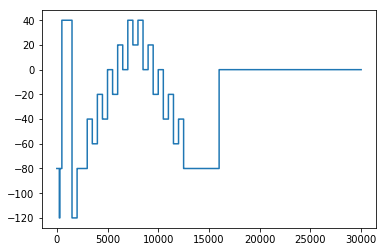

In [10]:
s.reset()
d = s.run(30000)

plt.figure()
plt.plot(d.time(), d['membrane.V'], drawstyle='steps-post')
plt.show()

## Logging at pre-defined intervals

Above, we saw some plotting effects and funny business that arose when we let the ODE solver determine which time points to log. When doing inference, we usually have a fixed data set that determines which points to log.

For example, assume we have these points:

In [11]:
import numpy as np
times = np.linspace(0, 15999, 16000)
print(times)

[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.5997e+04 1.5998e+04 1.5999e+04]


Then we can tell the solver to calculate a value for each of these points, using the `log_times` argument

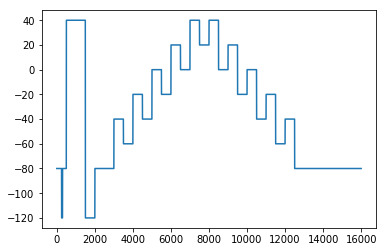

In [12]:
s = myokit.Simulation(m, p)
d = s.run(16000, log_times=times)
plt.figure()
plt.plot(d.time(), d['membrane.V'])
plt.show()

## Initial conditions

So far, we've ran simulations using the initial conditions specified in the model


In [13]:
print(m.get('ikr.act').state_value())

0.0


In [14]:
print(m.get('ikr.rec').state_value())

1.0


We can see this by looking closely at the start of the simulation:

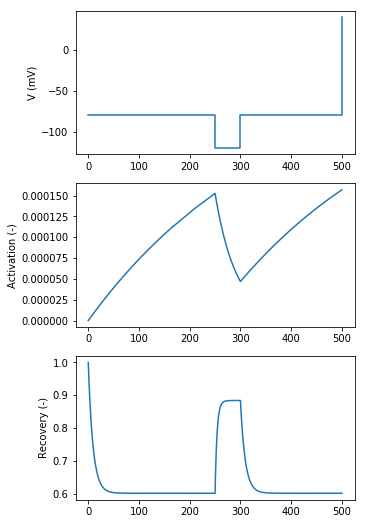

In [15]:
s.reset()
d = s.run(500)

plt.figure(figsize=(5, 9))
plt.subplot(3,1,1)
plt.ylabel('V (mV)')
plt.plot(d.time(), d['membrane.V'], drawstyle='steps-post')
plt.subplot(3,1,2)
plt.ylabel('Activation (-)')
plt.plot(d.time(), d['ikr.act'])
plt.subplot(3,1,3)
plt.ylabel('Recovery (-)')
plt.plot(d.time(), d['ikr.rec'])
plt.show()

As we can see, activation and recovery are already changing, before the first voltage step occurs at t=250ms

Ideally, we'd like to avoid this behaviour by setting more realistic steady-states. For example, we might simply start by running the model at a constant -80mV for a few seconds, and seeing where we end up. To do this, we can create a model where `membrane.V` does not get its value from a protocol, but is simply fixed at -80mV

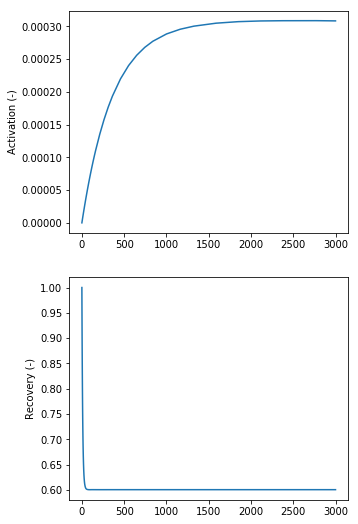

In [16]:
# Create a copy of the model
m2 = m.clone()

# Remove the binding to 'pace'
m2.get('membrane.V').set_binding(None)

s = myokit.Simulation(m2, protocol=None)
d = s.run(3000)

plt.figure(figsize=(5, 9))
plt.subplot(2,1,1)
plt.ylabel('Activation (-)')
plt.plot(d.time(), d['ikr.act'])
plt.subplot(2,1,2)
plt.ylabel('Recovery (-)')
plt.plot(d.time(), d['ikr.rec'])
plt.show()

Now we can look at the final simulation state and update our model accordingly:

In [17]:
print(s.state())

[0.00030849581078575266, 0.6008112006963034]


If we have a model in Hodgkin-Huxley form, we can do one better, and calculate the values analytically.

First, we take another look at the equations for activation:

In [18]:
print(m.get('ikr.act').code())

dot(act) = (inf - act) / tau
    inf = k1 * tau
    k1 = p1 * exp(p2 * V)
    k2 = p3 * exp(-p4 * V)
    tau = 1 / (k1 + k2)



The variable `inf` in this case represents the steady-state of activation. We can inspect its value in the model using the model API:

In [19]:
print(m.get('ikr.act.inf').value())

0.00030894931556590987


In [20]:
print(m.get('ikr.rec.inf').value())

0.60081119944226


We could even go one step further, and create a python function based on these variables:

In [21]:
a_inf = m.get('ikr.act.inf').pyfunc()
print(a_inf(-80))

0.00030894931556590987


This lets us inspect the steady states directly:

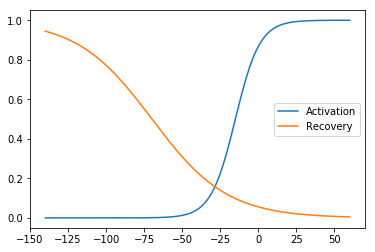

In [22]:
a_inf = m.get('ikr.act.inf').pyfunc()
r_inf = m.get('ikr.rec.inf').pyfunc()

voltages = np.linspace(-140, 60, 1000)

plt.figure()
plt.plot(voltages, a_inf(voltages), label='Activation')
plt.plot(voltages, r_inf(voltages), label='Recovery')
plt.legend()
plt.show()

We can do the whole thing programmatically as follows:

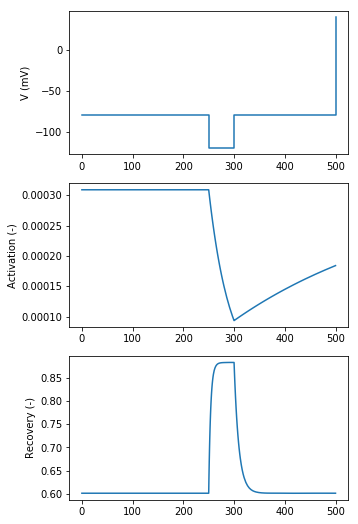

In [23]:
m = myokit.load_model('beattie-2017-ikr-hh.mmt')

m.get('ikr.act').set_state_value(m.get('ikr.act.inf').pyfunc()(-80))
m.get('ikr.rec').set_state_value(m.get('ikr.rec.inf').pyfunc()(-80))

p = myokit.load_protocol('staircase-protocol.mmt')
s = myokit.Simulation(m, p)

d = s.run(500)

plt.figure(figsize=(5, 9))
plt.subplot(3,1,1)
plt.ylabel('V (mV)')
plt.plot(d.time(), d['membrane.V'], drawstyle='steps-post')
plt.subplot(3,1,2)
plt.ylabel('Activation (-)')
plt.plot(d.time(), d['ikr.act'])
plt.subplot(3,1,3)
plt.ylabel('Recovery (-)')
plt.plot(d.time(), d['ikr.rec'])
plt.show()